In [ ]:
#
# David Laziuk
# 
# Experimenting with Auto-Pytorch package created by AutoML
#

In [ ]:
#Only works on Linux systems

In [1]:
import os
import tempfile as tmp
import warnings

from autoPyTorch.datasets.resampling_strategy import CrossValTypes

os.environ['JOBLIB_TEMP_FOLDER'] = tmp.gettempdir()
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

import sklearn.model_selection
import pandas as pd
from sklearn import metrics

from autoPyTorch.api.tabular_classification import TabularClassificationTask

In [2]:
#Loading Data
from sklearn.model_selection import train_test_split
data=pd.read_csv('diabetic_data.csv')
data.loc[data['readmitted']=='NO','readmitted']=0
data.loc[data['readmitted']=='<30','readmitted']=1
data.loc[data['readmitted']=='>30','readmitted']=1
data['readmitted']=data['readmitted'].astype('int8')

data=data.drop(columns=['encounter_id'])
data=data.drop(columns=['patient_nbr'])
data=data.drop(columns=['weight'])
data=data.drop(columns=['payer_code'])
data=data.drop(columns=['medical_specialty'])

nCat=['age','race','gender','admission_type_id','discharge_disposition_id','admission_source_id','diag_1','diag_2','diag_3','max_glu_serum',
     'A1Cresult','metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide','glipizide',
      'glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol','troglitazone','tolazamide','insulin',
      'glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone','metformin-pioglitazone','change','diabetesMed',
     'examide','citoglipton','metformin-rosiglitazone']

data[nCat]=data[nCat].astype('category')
data[nCat] = data[nCat].apply(lambda x: x.cat.codes)

X=data.iloc[:,0:-1]
y=data.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
data.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,3,0,0,5,23,0,1,41,0,1,...,0,1,1,0,0,0,0,1,0,0
1,3,0,1,0,0,6,3,59,0,18,...,0,3,1,0,0,0,0,0,1,1
2,1,0,2,0,0,6,2,11,5,13,...,0,1,1,0,0,0,0,1,1,0
3,3,1,3,0,0,6,2,44,1,16,...,0,3,1,0,0,0,0,0,1,0
4,3,1,4,0,0,6,1,51,0,8,...,0,2,1,0,0,0,0,0,1,0


In [3]:
api = TabularClassificationTask(
    seed=42,
)

In [4]:
api.search(
    memory_limit=None,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test.copy(),
    y_test=y_test.copy(),
    dataset_name='Diabetes',
    optimize_metric='accuracy',
    total_walltime_limit=1200,
    func_eval_time_limit_secs=180
    
)

[ERROR] [2022-12-02 20:48:31,999:Client-AutoPyTorch:Diabetes:42] Prediction for svm failed with run state StatusType.TIMEOUT.
Additional info:
error: Timeout
configuration_origin: traditional


In [5]:
y_pred = api.predict(X_test)
score = api.score(y_pred, y_test)
print(score)

# Print statistics from search
print(api.sprint_statistics())

{'accuracy': 0.6491107399037044}
autoPyTorch results:
	Dataset name: Diabetes
	Optimisation Metric: accuracy
	Best validation score: 0.6509342663589667
	Number of target algorithm runs: 13
	Number of successful target algorithm runs: 6
	Number of crashed target algorithm runs: 1
	Number of target algorithms that exceeded the time limit: 6
	Number of target algorithms that exceeded the memory limit: 0



In [6]:
api.refit(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    dataset_name="Diabetes",
)

[ERROR] [2022-12-02 21:12:57,202:Client-AutoPyTorch:RefitLogger:42] Prediction for lgb failed with run state StatusType.TIMEOUT.
Additional info:
error: Timeout
configuration_origin: traditional
[WARNING] [2022-12-02 21:12:57,202:Client-AutoPyTorch:RefitLogger:42] Not enough time to fit all machine learning models.Please consider increasing the run time to further improve performance.


In [7]:
y_pred = api.predict(X_test)
score = api.score(y_pred, y_test)
print(score)
# Print the final ensemble built by AutoPyTorch
print(api.show_models())

{'accuracy': 0.6491107399037044}
|    | Preprocessing                                                                                | Estimator                                                       |   Weight |
|---:|:---------------------------------------------------------------------------------------------|:----------------------------------------------------------------|---------:|
|  0 | None                                                                                         | LGBMLearner                                                     |     0.52 |
|  1 | None                                                                                         | CBLearner                                                       |     0.38 |
|  2 | SimpleImputer,Variance Threshold,NoCoalescer,NoEncoder,StandardScaler,NoFeaturePreprocessing | no embedding,ShapedMLPBackbone,FullyConnectedHead,nn.Sequential |     0.1  |


0    10952
1     9402
Name: readmitted, dtype: int64
[WARNING] [2022-12-02 21:13:22,396:matplotlib.font_manager] findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
[WARNING] [2022-12-02 21:13:22,409:matplotlib.font_manager] findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
[WARNING] [2022-12-02 21:13:22,421:matplotlib.font_manager] findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
[WARNING] [2022-12-02 21:13:22,472:matplotlib.font_manager] findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


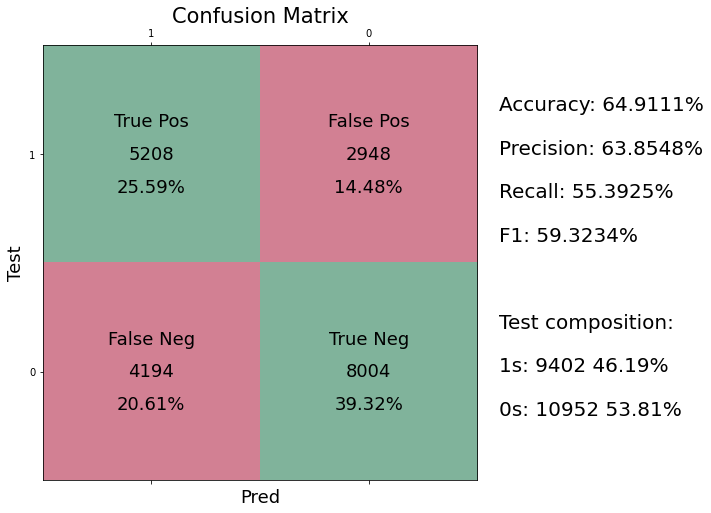

In [8]:
#Testing
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
#Getting confusion matrix
tn,fp,fn,tp=confusion_matrix(y_test,y_pred).ravel()
tot=tn+fp+fn+tp
#Structure of plot
cm=np.array(((1,0),(0,1)))
fig,ax=plt.subplots(figsize=(8,8))
plt.xlabel('Pred', fontsize=18)
plt.ylabel('Test', fontsize=18)
plt.title('Confusion Matrix', fontsize=21)
ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))
ax.set_xticklabels(['1','0'])
ax.set_yticklabels(['1','0'])
ax.matshow(cm,cmap='RdYlGn',alpha=0.5)
#Numeric vals
ax.text(0,0,s=tp,va='center',ha='center',fontsize=18)
ax.text(1,0,s=fp,va='center',ha='center',fontsize=18)
ax.text(0,1,s=fn,va='center',ha='center',fontsize=18)
ax.text(1,1,s=tn,va='center',ha='center',fontsize=18)
#Labels
ax.text(0,-.15,s="True Pos",va='center',ha='center',fontsize=18)
ax.text(1,-.15,s="False Pos",va='center',ha='center',fontsize=18)
ax.text(0,.85,s="False Neg",va='center',ha='center',fontsize=18)
ax.text(1,.85,s="True Neg",va='center',ha='center',fontsize=18)
#Percentages
ax.text(0,.15,s=str(round((tp/tot)*100,2))+'%' ,va='center',ha='center',fontsize=18)
ax.text(1,.15,s=str(round((fp/tot)*100,2))+'%' ,va='center',ha='center',fontsize=18)
ax.text(0,1.15,s=str(round((fn/tot)*100,2))+'%' ,va='center',ha='center',fontsize=18)
ax.text(1,1.15,s=str(round((tn/tot)*100,2))+'%' ,va='center',ha='center',fontsize=18)
#Result overview
acc=(tp+tn)/(tp+tn+fp+fn)
pre=(tp)/(tp+fp)
rec=(tp)/(tp+fn)
ax.text(1.6,-.2,"Accuracy: "+str(round((acc)*100 ,4))+'%',fontsize=20)
ax.text(1.6,0,"Precision: "+str(round((pre)*100 ,4))+'%',fontsize=20)
ax.text(1.6,.2,"Recall: "+str(round((rec)*100 ,4))+'%',fontsize=20)
ax.text(1.6,.4,"F1: "+str(round(( 2*((pre*rec)/(pre+rec)) )*100 ,4))+'%',fontsize=20)
c=y_test.value_counts()
print(c)
t1=c[1]
t0=c[0]
ax.text(1.6,.8,"Test composition:",fontsize=20)
ax.text(1.6,1,"1s: "+str(t1)+" "+str(round((t1/(t1+t0))*100 ,2))+'%',fontsize=20)
ax.text(1.6,1.2,"0s: "+str(t0)+" "+str(round((t0/(t1+t0))*100 ,2))+'%',fontsize=20)
del acc,ax,cm,fig,fn,fp,pre,rec,tn,tot,tp
plt.show()